In [5]:
# https://www.coursera.org/lecture/matematicheskaya-teoria-igr/itierativnyi-mietod-rieshieniia-matrichnykh-ighr-sfgod

In [2]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def analytic_solve(game_matrix):
    """
    inverted matrix analytic solve method
    :param game_matrix:
    :return: x (A strategy), y (B strategy), v (value)
    """
    m = len(game_matrix)
    u = np.ones(m)
    inv_game_matrix = np.linalg.inv(game_matrix)
    Cinvu = np.dot(inv_game_matrix, u.transpose())
    x = np.divide(
        Cinvu,
        np.dot(u, Cinvu)
    )
    uCinv = np.dot(u, inv_game_matrix)
    uCinvuinv = np.dot(uCinv, u.transpose())
    y = np.divide(
        uCinv,
        uCinvuinv
    )

    v = np.divide(1, uCinvuinv)
    return x, y, v

In [12]:
def brown_robinson_method(game_matrix: np.array, precision: float):
    """
    Brown Robinson iteration method to find the solution of the antagonistic matrix game
    :param game_matrix:
    :param precision: target precision
    :return: df, x (A strategy), y (B strategy), v (value)
    """
    a_strategies_count = len(game_matrix)
    b_strategies_count = len(game_matrix[0])
    a_strategies_column_names = [f'x{i + 1}' for i in range(a_strategies_count)]
    b_strategies_column_names = [f'y{i + 1}' for i in range(b_strategies_count)]

    df = pd.DataFrame(columns=[
        'A', 'B',
        *a_strategies_column_names,
        *b_strategies_column_names,
        'v_up', 'v_down', 'eps'
    ], dtype=np.int)

    a_strategy = random.randint(0, a_strategies_count - 1)
    b_strategy = random.randint(0, b_strategies_count - 1)

    round_num = 1
    v_up = game_matrix[:, a_strategy].max() / round_num
    v_down = game_matrix[b_strategy].min() / round_num
    eps = v_up - v_down
    df.loc[round_num] = [
        f"x{a_strategy + 1}",
        f"y{b_strategy + 1}",
        *game_matrix[:, b_strategy],
        *game_matrix[a_strategy],
        v_up,
        v_down,
        eps
    ]

    a_strategies_pos_start = 2
    a_strategies_pos_stop = a_strategies_pos_start + a_strategies_count

    b_strategies_pos_start = a_strategies_pos_stop
    b_strategies_pos_stop = a_strategies_pos_stop + b_strategies_count

    while eps > precision:
        round_num += 1

        prev_round_a = pd.DataFrame(df.loc[round_num - 1][a_strategies_pos_start: a_strategies_pos_stop], dtype=np.int)
        prev_round_b = pd.DataFrame(df.loc[round_num - 1][b_strategies_pos_start: b_strategies_pos_stop], dtype=np.int)

        # name of column with minimal value in A/B strategies range
        a_new_strategy_str = prev_round_a.idxmax().iloc[0]
        b_new_strategy_str = prev_round_b.idxmin().iloc[0]

        a_strategy = int(a_new_strategy_str[1:]) - 1
        b_strategy = int(b_new_strategy_str[1:]) - 1

        round_a = game_matrix[:, b_strategy] + prev_round_a.T
        round_b = game_matrix[a_strategy] + prev_round_b.T
        v_up = round_a.max(axis=1).iloc[0] / round_num
        v_down = round_b.min(axis=1).iloc[0] / round_num

        df.loc[round_num] = [
            a_new_strategy_str,
            b_new_strategy_str,
            *round_a.iloc[0].T,
            *round_b.iloc[0].T,
            v_up,
            v_down,
            None
        ]

        eps = float(df[['v_up']].min()) - float(df[['v_down']].max())
        df.at[round_num, 'eps'] = eps
    
    xx = (df['A'].value_counts() / round_num).sort_index()
    yy = (df['B'].value_counts() / round_num).sort_index()
    vv = (df['v_down'].max() + df['v_up'].min()) / 2
    
    x = [xx.get(col_name, 0) for col_name in a_strategies_column_names]
    y = [yy.get(col_name, 0) for col_name in b_strategies_column_names]

    return df, x, y, vv

In [16]:
game_matrix = np.array(
    [
        [18, 13, 15],
        [0, 13, 16],
        [1, 17, 9],
    ]
)
precision = 1 / 10

In [17]:
x, y, v = analytic_solve(game_matrix)
print("Analytic inverse matrix method:")
print("x* - A mixed strategy")
print("y* - B mixed strategy")
print(f"x* = {x}; y* = {y}; value = {v}")

Analytic inverse matrix method:
x* - A mixed strategy
y* - B mixed strategy
x* = [0.0199005  0.62189055 0.35820896]; y* = [0.75621891 0.039801   0.2039801 ]; value = 13.81592039800995


In [18]:
df, xx, yy, vv = brown_robinson_method(game_matrix, precision)

print("Iteration method:")
print("x* - A mixed strategy")
print("y* - B mixed strategy")
print(df)
print(f"x* = {xx}; y* = {yy}; value = {float(vv)}")

Iteration method:
x* - A mixed strategy
y* - B mixed strategy
     A   B   x1   x2   x3   y1   y2   y3       v_up     v_down        eps
1   x1  y2   13   13   17   18   13   15  18.000000   0.000000         18
2   x3  y2   26   26   34   19   30   24  17.000000   9.500000        7.5
3   x3  y1   44   26   35   20   47   33  14.666667   6.666667    5.16667
4   x1  y1   62   26   36   38   60   48  15.500000   9.500000    5.16667
5   x1  y1   80   26   37   56   73   63  16.000000  11.200000    3.46667
6   x1  y1   98   26   38   74   86   78  16.333333  12.333333    2.33333
7   x1  y1  116   26   39   92   99   93  16.571429  13.142857    1.52381
8   x1  y1  134   26   40  110  112  108  16.750000  13.500000    1.16667
9   x1  y3  149   42   49  128  125  123  16.555556  13.666667          1
10  x1  y3  164   58   58  146  138  138  16.400000  13.800000   0.866667
11  x1  y2  177   71   75  164  151  153  16.090909  13.727273   0.866667
12  x1  y2  190   84   92  182  164  168  15.83333

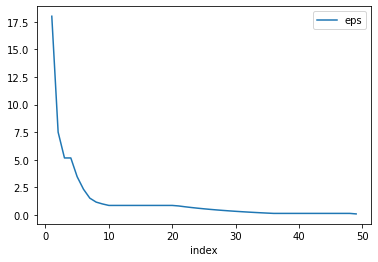

In [19]:
ax = plt.gca()
df.reset_index().plot(kind='line', x='index', y='eps', ax=ax)
plt.show()

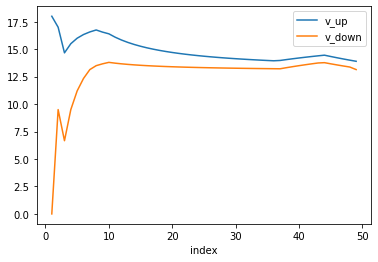

In [20]:
ax = plt.gca()
df.reset_index().plot(kind='line', x='index', y='v_up', ax=ax)
df.reset_index().plot(kind='line', x='index', y='v_down', ax=ax)
plt.show()